In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
import os

for dirname, _, filenames in os.walk("../Data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../Data\ADANIPORTS.csv
../Data\ASIANPAINT.csv
../Data\AXISBANK.csv
../Data\BAJAJ-AUTO.csv
../Data\BAJAJFINSV.csv
../Data\BAJFINANCE.csv
../Data\BHARTIARTL.csv
../Data\BPCL.csv
../Data\BRITANNIA.csv
../Data\CIPLA.csv
../Data\COALINDIA.csv
../Data\DRREDDY.csv
../Data\EICHERMOT.csv
../Data\GAIL.csv
../Data\GRASIM.csv
../Data\HCLTECH.csv
../Data\HDFC.csv
../Data\HDFCBANK.csv
../Data\HEROMOTOCO.csv
../Data\HINDALCO.csv
../Data\HINDUNILVR.csv
../Data\ICICIBANK.csv
../Data\INDUSINDBK.csv
../Data\INFRATEL.csv
../Data\INFY.csv
../Data\IOC.csv
../Data\ITC.csv
../Data\JSWSTEEL.csv
../Data\KOTAKBANK.csv
../Data\LT.csv
../Data\MARUTI.csv
../Data\MM.csv
../Data\NESTLEIND.csv
../Data\NIFTY50_all.csv
../Data\NTPC.csv
../Data\ONGC.csv
../Data\POWERGRID.csv
../Data\RELIANCE.csv
../Data\SBIN.csv
../Data\SHREECEM.csv
../Data\stock_metadata.csv
../Data\SUNPHARMA.csv
../Data\TATAMOTORS.csv
../Data\TATASTEEL.csv
../Data\TCS.csv
../Data\TECHM.csv
../Data\TITAN.csv
../Data\ULTRACEMCO.csv
../Data\UPL.csv
../Dat

In [3]:
# Combining All the csv files in one file
file_paths = glob.glob("../Data/*.csv")

num_file_paths = len(file_paths)
print(f"Number of file paths found: {num_file_paths}")

Number of file paths found: 52


In [4]:
# Reading each CSV file and store in a list
dfs = []
for file_path in file_paths:
    # Avoiding reading metadata file
    if "stock_metadata" not in file_path and "NIFTY50_all" not in file_path:
        df = pd.read_csv(file_path, parse_dates=["Date"])
        df["Stock"] = file_path.split("\\")[-1].replace(
            ".csv", ""
        )  # Adding stock name column
        dfs.append(df)

In [5]:
Nifty_50 = pd.concat(dfs, ignore_index=True)
Nifty_50.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Stock
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612,ADANIPORTS
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172,ADANIPORTS
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088,ADANIPORTS
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735,ADANIPORTS
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741,ADANIPORTS


In [6]:
Nifty_50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235192 entries, 0 to 235191
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Date                235192 non-null  datetime64[ns]
 1   Symbol              235192 non-null  object        
 2   Series              235192 non-null  object        
 3   Prev Close          235192 non-null  float64       
 4   Open                235192 non-null  float64       
 5   High                235192 non-null  float64       
 6   Low                 235192 non-null  float64       
 7   Last                235192 non-null  float64       
 8   Close               235192 non-null  float64       
 9   VWAP                235192 non-null  float64       
 10  Volume              235192 non-null  object        
 11  Turnover            235192 non-null  float64       
 12  Trades              120344 non-null  float64       
 13  Deliverable Volume  219115 no

In [7]:
Nifty50 = df

In [8]:
# Ensure that 'Date' is a datetime object and sort by date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

# Calculate rolling max and min for different time periods

# Day-to-day
df["Prev_Max_Day"] = df["Close"].shift(1)
df["Prev_Min_Day"] = df["Close"].shift(1)

# Week-to-week
df["Prev_Max_Week"] = (
    df["Close"].rolling(window=7).max().shift(7)
)  # Previous week max (shift by 7 days)
df["Prev_Min_Week"] = (
    df["Close"].rolling(window=7).min().shift(7)
)  # Previous week min

# Month-to-month
df["Prev_Max_Month"] = (
    df["Close"].rolling(window=30).max().shift(30)
)  # Previous month max (shift by 30 days)
df["Prev_Min_Month"] = (
    df["Close"].rolling(window=30).min().shift(30)
)  # Previous month min


# Buy = True if current period's min is greater than previous period's max, else False
df["Buy_Sell_Indicator_Day"] = df["Close"] > df["Prev_Max_Day"]
df["Buy_Sell_Indicator_Week"] = (
    df["Close"].rolling(window=7).min() > df["Prev_Max_Week"]
)
df["Buy_Sell_Indicator_Month"] = (
    df["Close"].rolling(window=30).min() > df["Prev_Max_Month"]
)

# Drop NaN values that were created due to rolling and shifting
df.dropna(inplace=True)

# View the result
print(
    df[
        [
            "Date",
            "Close",
            "Stock",
            "Buy_Sell_Indicator_Day",
            "Buy_Sell_Indicator_Week",
            "Buy_Sell_Indicator_Month",
        ]
    ]
)

           Date   Close Stock  Buy_Sell_Indicator_Day  \
2850 2011-06-01  139.75  ZEEL                    True   
2851 2011-06-02  143.05  ZEEL                    True   
2852 2011-06-03  140.25  ZEEL                   False   
2853 2011-06-06  140.00  ZEEL                   False   
2854 2011-06-07  144.65  ZEEL                    True   
...         ...     ...   ...                     ...   
5301 2021-04-26  186.40  ZEEL                   False   
5302 2021-04-27  188.15  ZEEL                    True   
5303 2021-04-28  189.10  ZEEL                    True   
5304 2021-04-29  186.55  ZEEL                   False   
5305 2021-04-30  185.60  ZEEL                   False   

      Buy_Sell_Indicator_Week  Buy_Sell_Indicator_Month  
2850                     True                     False  
2851                     True                     False  
2852                    False                     False  
2853                    False                     False  
2854                    F

Predicted next smoothed value: 422.78649204113776


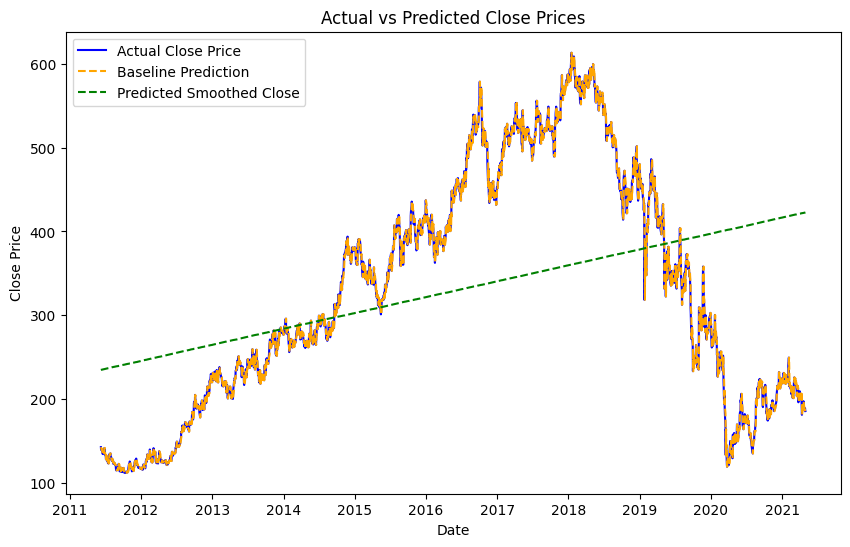

In [9]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

# Calculate a moving average to smooth the data
df["MA_Smoothed"] = df["Close"].rolling(window=7).mean()

# Drop NaN values from the rolling window to avoid issues in model training
df.dropna(subset=["MA_Smoothed"], inplace=True)

# 1. Baseline Prediction: Predict the next value using a persistence model (previous value)
df["Baseline_Predicted_Close"] = df["Close"].shift(1)

# 2. Smoothed Data Prediction: Predicting the next smoothed value
# Prepare data for linear regression
X = np.arange(len(df["MA_Smoothed"])).reshape(-1, 1)  # Time steps
y = df["MA_Smoothed"].values  # Smoothed closing prices (without NaN values)

# Train linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the next value for the smoothed data
next_time_step = np.array([[len(df)]])  # Next time step
predicted_value = model.predict(next_time_step)

# Predict smoothed close prices for the entire dataset
df["Predicted_Smoothed_Close"] = model.predict(X)

# Display the next predicted value
print(f"Predicted next smoothed value: {predicted_value[0]}")

# Plot the original vs predicted
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Close"], label="Actual Close Price", color="blue")
plt.plot(
    df["Date"],
    df["Baseline_Predicted_Close"],
    label="Baseline Prediction",
    linestyle="--",
    color="orange",
)
plt.plot(
    df["Date"],
    df["Predicted_Smoothed_Close"],
    label="Predicted Smoothed Close",
    linestyle="--",
    color="green",
)
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

Predicted next weekly mean: 421.441492622914
Predicted next weekly variance: 112.79582871328327
Predicted next monthly mean: 422.3139385595865
Predicted next monthly variance: 375.4669159997293


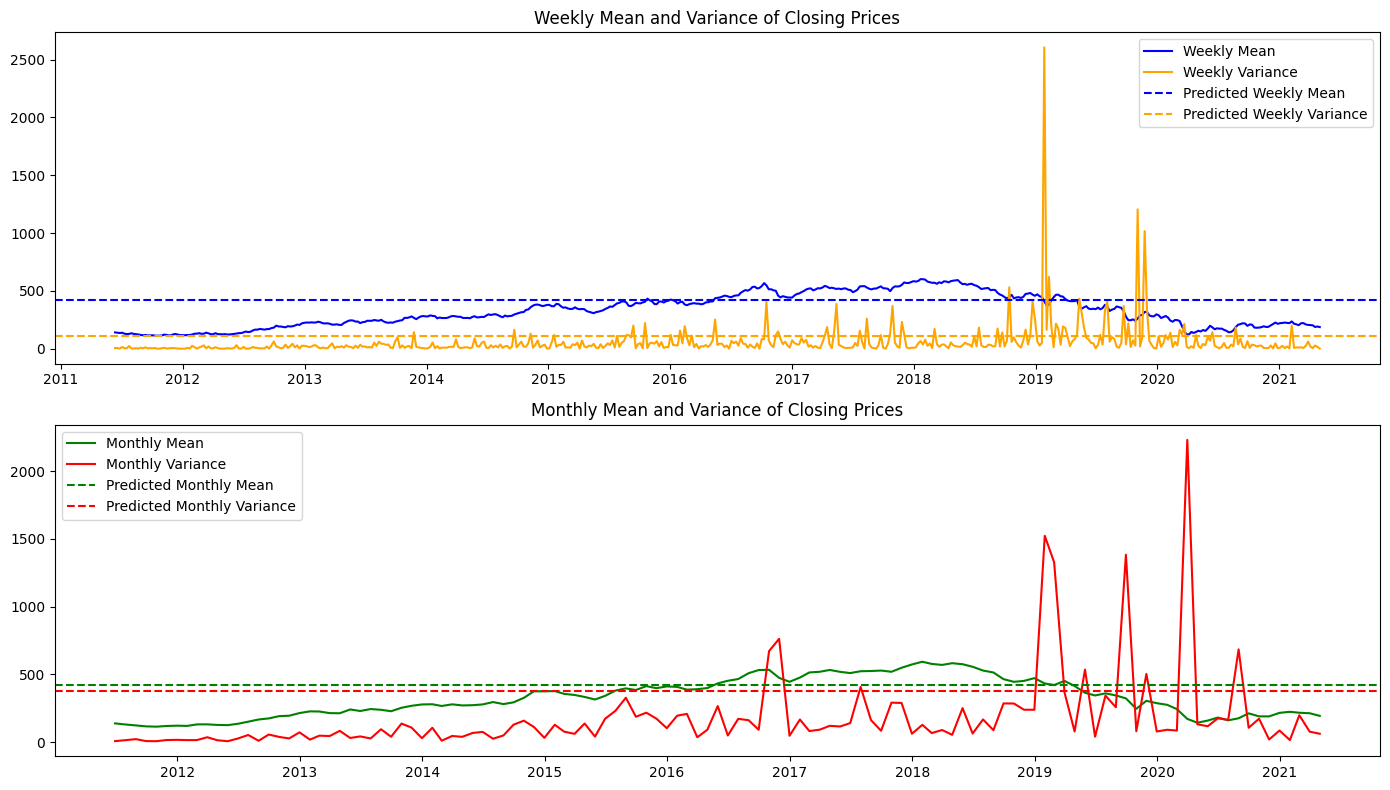

In [10]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

# Setting the Date column as the index for easy resampling
df.set_index("Date", inplace=True)

# Weekly distribution parameters (mean and variance)
df_weekly = df["Close"].resample("W").agg(["mean", "var"])
df_weekly.columns = ["Weekly_Mean", "Weekly_Variance"]

# Monthly distribution parameters (mean and variance)
df_monthly = df["Close"].resample("M").agg(["mean", "var"])
df_monthly.columns = ["Monthly_Mean", "Monthly_Variance"]

# Prepare data for predicting future weekly mean and variance
# Drop NaN values as initial periods of variance might be NaN
df_weekly.dropna(inplace=True)
df_monthly.dropna(inplace=True)

# Set up linear regression models for predicting the weekly mean and variance
X_weekly = np.arange(len(df_weekly)).reshape(-1, 1)  # Time steps for weekly
y_weekly_mean = df_weekly["Weekly_Mean"].values
y_weekly_var = df_weekly["Weekly_Variance"].values

model_mean_weekly = LinearRegression()
model_var_weekly = LinearRegression()

# Train models on weekly data
model_mean_weekly.fit(X_weekly, y_weekly_mean)
model_var_weekly.fit(X_weekly, y_weekly_var)

# Predict future weekly mean and variance
next_time_step_weekly = np.array([[len(df_weekly)]])
predicted_weekly_mean = model_mean_weekly.predict(next_time_step_weekly)
predicted_weekly_var = model_var_weekly.predict(next_time_step_weekly)

# Set up linear regression models for predicting the monthly mean and variance
X_monthly = np.arange(len(df_monthly)).reshape(-1, 1)  # Time steps for monthly
y_monthly_mean = df_monthly["Monthly_Mean"].values
y_monthly_var = df_monthly["Monthly_Variance"].values

model_mean_monthly = LinearRegression()
model_var_monthly = LinearRegression()

# Train models on monthly data
model_mean_monthly.fit(X_monthly, y_monthly_mean)
model_var_monthly.fit(X_monthly, y_monthly_var)

# Predict future monthly mean and variance
next_time_step_monthly = np.array([[len(df_monthly)]])
predicted_monthly_mean = model_mean_monthly.predict(next_time_step_monthly)
predicted_monthly_var = model_var_monthly.predict(next_time_step_monthly)

# Display predictions
print(f"Predicted next weekly mean: {predicted_weekly_mean[0]}")
print(f"Predicted next weekly variance: {predicted_weekly_var[0]}")
print(f"Predicted next monthly mean: {predicted_monthly_mean[0]}")
print(f"Predicted next monthly variance: {predicted_monthly_var[0]}")

# Plot weekly and monthly mean and variance
plt.figure(figsize=(14, 8))

# Weekly plot
plt.subplot(2, 1, 1)
plt.plot(
    df_weekly.index,
    df_weekly["Weekly_Mean"],
    label="Weekly Mean",
    color="blue",
)
plt.plot(
    df_weekly.index,
    df_weekly["Weekly_Variance"],
    label="Weekly Variance",
    color="orange",
)
plt.axhline(
    y=predicted_weekly_mean[0],
    color="blue",
    linestyle="--",
    label="Predicted Weekly Mean",
)
plt.axhline(
    y=predicted_weekly_var[0],
    color="orange",
    linestyle="--",
    label="Predicted Weekly Variance",
)
plt.title("Weekly Mean and Variance of Closing Prices")
plt.legend()

# Monthly plot
plt.subplot(2, 1, 2)
plt.plot(
    df_monthly.index,
    df_monthly["Monthly_Mean"],
    label="Monthly Mean",
    color="green",
)
plt.plot(
    df_monthly.index,
    df_monthly["Monthly_Variance"],
    label="Monthly Variance",
    color="red",
)
plt.axhline(
    y=predicted_monthly_mean[0],
    color="green",
    linestyle="--",
    label="Predicted Monthly Mean",
)
plt.axhline(
    y=predicted_monthly_var[0],
    color="red",
    linestyle="--",
    label="Predicted Monthly Variance",
)
plt.title("Monthly Mean and Variance of Closing Prices")
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
print(df.columns)

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'Stock', 'Prev_Max_Day', 'Prev_Min_Day', 'Prev_Max_Week',
       'Prev_Min_Week', 'Prev_Max_Month', 'Prev_Min_Month',
       'Buy_Sell_Indicator_Day', 'Buy_Sell_Indicator_Week',
       'Buy_Sell_Indicator_Month', 'MA_Smoothed', 'Baseline_Predicted_Close',
       'Predicted_Smoothed_Close'],
      dtype='object')


In [12]:
from sklearn.metrics import mean_squared_error


def generate_fixed_window_features(df, window_size=30):
    """
    Generate feature vectors using a fixed window history for a single stock.

    Parameters:
    - df (pd.DataFrame): DataFrame containing stock data with 'Close' prices.
    - window_size (int): Number of days in the window to use for prediction.

    Returns:
    - X (np.array): Feature vectors containing historical close prices.
    - y (np.array): Target values representing the next day's close price.
    """
    feature_vectors = []
    targets = []

    # Create feature vectors with a fixed window
    for i in range(window_size, len(df)):
        # Use the last 'window_size' closing prices as features
        feature_vectors.append(df["Close"].values[i - window_size : i])
        # The target is the next day's closing price
        targets.append(df["Close"].values[i])

    X = np.array(feature_vectors)
    y = np.array(targets)
    return X, y

In [13]:
print(df.columns)

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble', 'Stock', 'Prev_Max_Day', 'Prev_Min_Day', 'Prev_Max_Week',
       'Prev_Min_Week', 'Prev_Max_Month', 'Prev_Min_Month',
       'Buy_Sell_Indicator_Day', 'Buy_Sell_Indicator_Week',
       'Buy_Sell_Indicator_Month', 'MA_Smoothed', 'Baseline_Predicted_Close',
       'Predicted_Smoothed_Close'],
      dtype='object')


Mean Squared Error on training data: 107.04
Predicted next closing price: 184.27872064178555


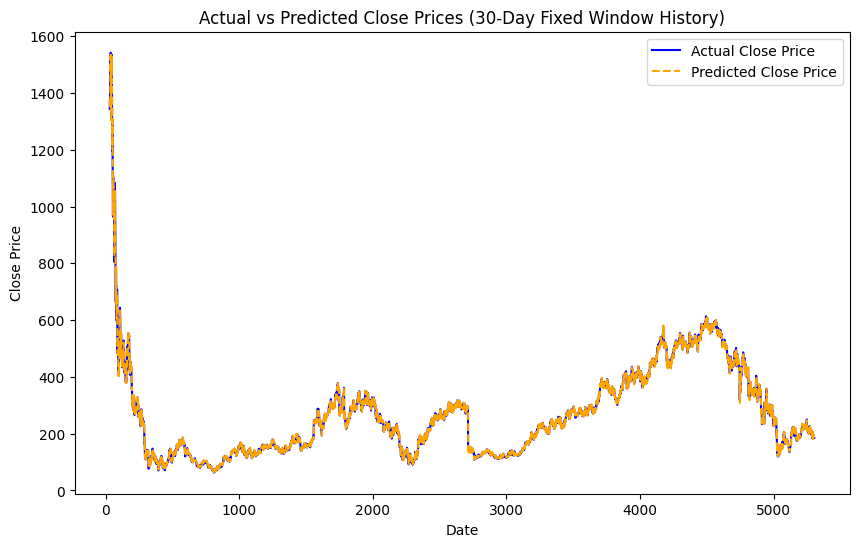

In [14]:
# Ensure the dataframe is sorted by date and indexed by date for consistency
df = pd.read_csv(file_path, parse_dates=["Date"])

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

# Generate features and targets using a 30-day window
X, y = generate_fixed_window_features(df, window_size=30)

# Reshape X for linear regression
X = X.reshape(X.shape[0], -1)  # Flatten each window for regression

# Train the Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Calculate predictions on the training data
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error on training data: {mse:.2f}")


# Use the last 30 days of data as the input for predicting the next closing price
latest_window = (
    df["Close"].values[-30:].reshape(1, -1)
)  # Reshape to 2D for prediction
predicted_next_value = model.predict(latest_window)
print(f"Predicted next closing price: {predicted_next_value[0]}")


# Plot actual vs predicted values for the training data
plt.figure(figsize=(10, 6))
plt.plot(df.index[30:], y, label="Actual Close Price", color="blue")
plt.plot(
    df.index[30:],
    y_pred,
    label="Predicted Close Price",
    linestyle="--",
    color="orange",
)
plt.legend()
plt.title("Actual vs Predicted Close Prices (30-Day Fixed Window History)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [15]:
# 1. Load your dataset (ensure 'Date' and 'Close' columns exist)
# df = pd.read_csv("your_data.csv", parse_dates=["Date"])
df = df.sort_values("Date")

# 2. Normalize the 'Close' column using MinMaxScaler for faster training
scaler = MinMaxScaler(feature_range=(0, 1))
df["Close"] = scaler.fit_transform(df[["Close"]])

# 3. Set the time window (number of previous days to consider)
time_window = 30  # for a 30-day history


# 4. Prepare the sequences for the LSTM model
def create_sequences(data, time_window):
    X = []
    y = []
    for i in range(len(data) - time_window):
        X.append(data[i : i + time_window])
        y.append(data[i + time_window])
    return np.array(X), np.array(y)


# Convert 'Close' values to sequences
X, y = create_sequences(df["Close"].values, time_window)

# Reshape X to be [samples, time steps, features] as expected by LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

c:\Users\nikhi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.0033 - val_loss: 2.8591e-04
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.3167e-04 - val_loss: 5.0556e-04
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.6607e-04 - val_loss: 1.7730e-04
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.8799e-04 - val_loss: 2.5563e-04
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.9226e-04 - val_loss: 2.5651e-04
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.9111e-04 - val_loss: 3.6151e-04
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.1771e-04 - val_loss: 1.0449e-04
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.6688e-04 - val_loss: 2.5445e-04
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.6280e-04 - val_loss: 1.0318e-04
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.6612e-04 - val_loss: 9.4662e-05
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/ste

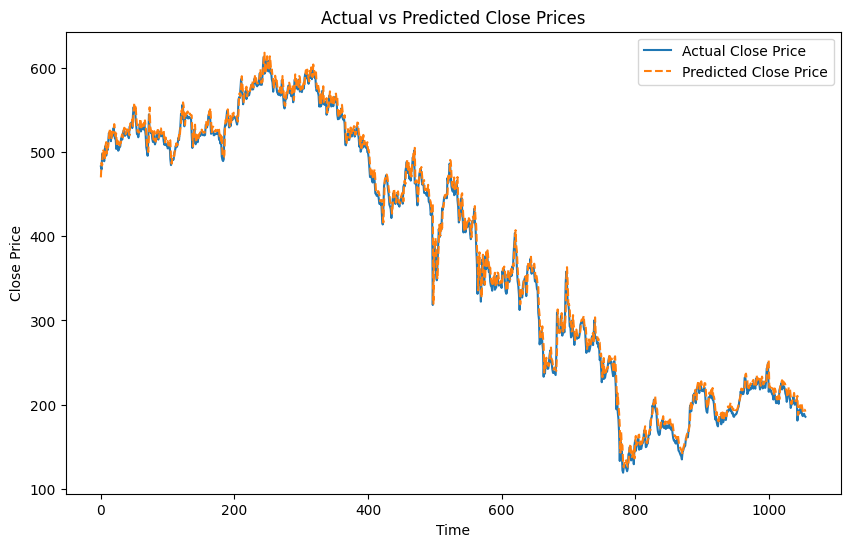

In [16]:
# Define the LSTM model
model = Sequential(
    [
        LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
        LSTM(50),
        Dense(1),  # Output layer for regression
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Display model summary
model.summary()

# Split data into training and testing sets
split_ratio = 0.8
train_size = int(len(X) * split_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
)

# Predict on the test set
predictions = model.predict(X_test)

# Inverse transform the predictions and true values to original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual Close Price")
plt.plot(predictions, label="Predicted Close Price", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.show()